# *Diagnosis of monkeypox disease based on computer vision using images of skin lesions: a comparative study (by Reihaneh Shakiba)*

#**download the dataset and set it in google drive** :

In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/monkey"

# %cd /content/drive/MyDrive/monkey

# ! kaggle datasets download -d piyush19/monkeypox-dataset

# !unzip /content/drive/MyDrive/monkey/monkeypox-dataset.zip -d /content/drive/MyDrive/monkey/dat


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import section** :

In [ ]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from operator import index
import random
import time
import re

#**load the data from google drive**:

In [ ]:
def load_data(dir):
  """
  this function loads the data from our
  directions and create dataframes to process them
  and return (train _ valid _ test) dataframes
  that train dataframe include 75% of our data

  """
  image_path = []
  label = []
  class_list = os.listdir(dir)
  print("our classes in the dataset are : ",class_list,"\n")

  for cls in class_list :

    # create path folder
    each_class_path = os.path.join(dir , cls)

    # read images inside the class folders
    image_in_class_path = os.listdir(each_class_path)
    print(f'the number of ( {cls} ) class is : ',len(image_in_class_path))

    for img in image_in_class_path:

      # join classpath + image  like : user/monkey_pox/image_100.png
      image_path.append(os.path.join(each_class_path , img))

      # extract each pure name (without number) of image
      name_img = re.match(r'^([a-zA-Z]+)',img).group(1)
      label.append(name_img)

  print("\nlen label and len image must be equal -> \n"
        f'len image path is : {len(image_path)} \n'
        f'len label path is : {len(label)}\n')

  # create series to create a pandas dataframe
  image_series = pd.Series(image_path, name= 'image_path')
  label_series = pd.Series(label, name= 'label')

  #create dataframe
  df = pd.concat([image_series , label_series] , axis=1)
  print(f'our dataframe is : \n{df}\n')

  # create train validation and test dataframes from main df
  train_df, dummy_df = train_test_split(df, train_size=.75,
                                      shuffle=True, random_state=123,
                                      stratify=df['label'])

  valid_df, test_df = train_test_split(dummy_df, train_size=.5,
                                     shuffle=True, random_state=123,
                                     stratify=dummy_df['label'])

  # print the dataframes
  print(f'train_dataframe lenght: {len(train_df)} \n'
        f'test_dataframe  length: {len(test_df)} \n'
        f'valid_dataframe length: {len(valid_df)} \n')

  return train_df, valid_df, test_df




# call the load data function :
dir = '/content/drive/MyDrive/monkey/data/Augmented/Augmented'
train_df, valid_df, test_df = load_data(dir)

our classes in the dataset are :  ['monkeypox', 'others'] 

the number of ( monkeypox ) class is :  5064
the number of ( others ) class is :  4836

len label and len image must be equal -> 
len image path is : 9900 
len label path is : 9900

our dataframe is : 
                                             image_path      label
0     /content/drive/MyDrive/monkey/data/Augmented/A...  monkeypox
1     /content/drive/MyDrive/monkey/data/Augmented/A...  monkeypox
2     /content/drive/MyDrive/monkey/data/Augmented/A...  monkeypox
3     /content/drive/MyDrive/monkey/data/Augmented/A...  monkeypox
4     /content/drive/MyDrive/monkey/data/Augmented/A...  monkeypox
...                                                 ...        ...
9895  /content/drive/MyDrive/monkey/data/Augmented/A...     others
9896  /content/drive/MyDrive/monkey/data/Augmented/A...     others
9897  /content/drive/MyDrive/monkey/data/Augmented/A...     others
9898  /content/drive/MyDrive/monkey/data/Augmented/A...     others
9

#**create a machine learning data generator** :
1. ml_data_generator
2. save_numpy
3. laod the saved numpy


In [ ]:
def ml_data_generator(df,image_size):
  """
  here we process the data to be ready for
  machine learning algorithm
  process :
  1.resize
  2.rshape to vector
  3.normalize the data

  """
  # get images from dataframe
  images = []
  for file_path in df['image_path']:
    img = cv2.imread(file_path)
    # resize the image
    img = cv2.resize(img,image_size)
    # set the defult color rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

  # flatten
  images = np.array(images)
  images = images.reshape(len(images), -1)
  # normalize the images
  scaler = StandardScaler()
  images = scaler.fit_transform(images)

  # create one hot labels
  label_encoder = LabelEncoder()
  labels = label_encoder.fit_transform(df['label'])

  return images, labels

# call the ml data generator to generate datas
size = (100,100)
ml_train_image, ml_train_label = ml_data_generator(train_df,size)
ml_valid_image, ml_valid_label = ml_data_generator(valid_df,size)
ml_test_image, ml_test_label = ml_data_generator(test_df,size)

print(f'ml_train_shape is : {ml_train_image.shape}\n'
      f'ml_train_label is : {ml_train_label.shape}')

ml_train_shape is : (7425, 30000)
ml_train_label is : (7425,)


In [ ]:
def save_numpy(file_name, path, numpy):
  """"
  the machine learning process on data
  is take long time
  so we stored the process data to
  use them when ever we need it

  """
  # create path and names
  dummy_path = os.path.join(path, file_name)
  numpy_path = dummy_path + ".npy"

  # delete if there is file
  if os.path.exists(numpy_path):
    print("this file is already here , it will be replaced")
    os.remove(numpy_path)

  # save the file
  np.save(numpy_path, numpy)
  print(f"Model saved to {numpy_path}")



# calling the function and saving the data tht prepaered for ml model
numpy_path = "/content/drive/MyDrive/monkey/data/numpy_data/"
save_numpy("ml_train_image", numpy_path, ml_train_image)
save_numpy("ml_train_label", numpy_path, ml_train_label)
save_numpy("ml_valid_image", numpy_path, ml_valid_image)
save_numpy("ml_valid_label", numpy_path, ml_valid_label)
save_numpy("ml_test_image", numpy_path, ml_test_image)
save_numpy("ml_test_label", numpy_path, ml_test_label)

In [ ]:
def laod_numpy(path_file):
  """
  load the processed images for
  machine learning models

  """
  # laod the data
  dummy = np.load(path_file)
  return dummy

# call the function and load the data
#ml_train_image = laod_numpy("/content/drive/MyDrive/monkey/data/numpy_data/ml_train_image.npy")
ml_train_label = laod_numpy("/content/drive/MyDrive/monkey/data/numpy_data/ml_train_label.npy")
#ml_valid_image = laod_numpy("/content/drive/MyDrive/monkey/data/numpy_data/ml_valid_image.npy")
ml_valid_label = laod_numpy("/content/drive/MyDrive/monkey/data/numpy_data/ml_valid_label.npy")
#ml_test_image =  laod_numpy("/content/drive/MyDrive/monkey/data/numpy_data/ml_test_image.npy")
#ml_test_label =  laod_numpy("/content/drive/MyDrive/monkey/data/numpy_data/ml_test_label.npy")

# **create deep learning data generator**
1. deep learning data generator
2. plot the generated data

In [ ]:
def dl_data_generator(train_df,valid_df,test_df):
  """
  this generator prepaer data for
  deep learning models
  and we can here augments data later

  """

  batch_size= 15
  image_size= (224,224)
  generator= ImageDataGenerator(rescale=1./255)


  train_gen = generator.flow_from_dataframe(train_df, x_col='image_path',
                                            y_col='label',
                                            target_size=image_size,
                                            class_mode='binary',
                                            color_mode= 'rgb',
                                            shuffle=False,
                                            batch_size=batch_size)

  valid_gen = generator.flow_from_dataframe(valid_df, x_col='image_path',
                                            y_col='label',
                                            target_size=image_size,
                                            class_mode='binary',
                                            color_mode= 'rgb',
                                            shuffle=False,
                                            batch_size=batch_size)

  test_gen = generator.flow_from_dataframe(test_df, x_col='image_path',
                                           y_col='label',
                                            target_size=image_size,
                                           class_mode='binary',
                                            color_mode= 'rgb',
                                           shuffle=False,
                                            batch_size=batch_size)
  return train_gen, valid_gen, test_gen

# calling the dl generator
train_gen, valid_gen, test_gen = dl_data_generator(train_df,valid_df,test_df)

Found 7425 validated image filenames belonging to 2 classes.
Found 1237 validated image filenames belonging to 2 classes.
Found 1238 validated image filenames belonging to 2 classes.


**showing deep learning data generator pictures that preprocessed for cheack**

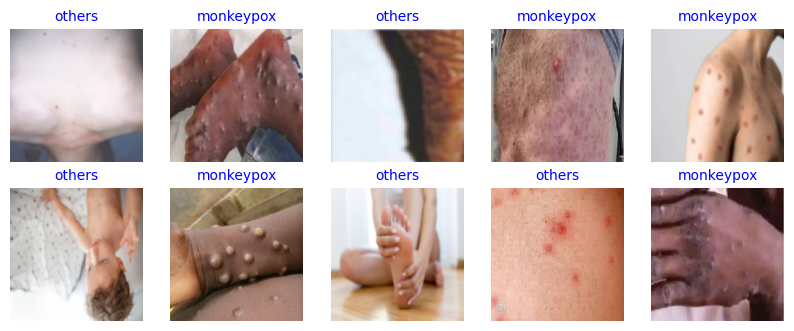

In [ ]:
def show_images_with_labels(gen, num):
    classes = list(gen.class_indices.keys())

    plt.figure(figsize=(10, 10))

    for _ in range(num):
        image, label = next(gen)
        image = image[0]  # Get the image from the batch
        label = int(label[0])  # Get the label from the batch

        plt.subplot(5, 5, _ + 1)
        plt.imshow(image)

        class_name = classes[label]
        plt.title(class_name, color='blue', fontsize=10)
        plt.axis('off')

    plt.show()

show_images_with_labels(test_gen, 10)

# **XGBOOST MODEL**
1. report ml model (confusion matrix)
2. save ml model
3. plot ml model
4. xgboost_1
5. xgboost_2
6. xgboost_3

In [ ]:
def report_ml_model(y_test, y_pred):

  """
  create a function to report the
  model precision  recall  f1-score

  """
  # classification report for ml model
  print('\n--------------- Classification Report ---------------\n')
  print(classification_report(y_test, y_pred),'\n')

In [ ]:
def save_ml_model(model, model_name, model_dir):
    """
    Save an machine learning model to disk with
     a given name and directory

    """
    import pickle

    # Create the path where the model file will be saved
    path = os.path.join(model_dir, model_name)
    model_path = path + ".dat"

    if os.path.exists(model_path):
      print("this file is already here , it will be replaced")
      os.remove(model_path)

    pickle.dump(model, open(model_path, "wb"))

    # Print a message to confirm that the model was saved
    print(f"Model saved to {model_path}")

In [ ]:
# XGBOOST PART
def plot_ml_model(x_axis, results):

  """
  cretae a function to plot the model
  logloss and error
  validation_0 : means training
  validation_1 : means validation

  """
  # xgboost logloss plot
  fig , ax = plt.subplots(figsize=(9,5))
  ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
  ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
  ax.legend()
  plt.ylabel('logloss')
  plt.title('XGBoost logloss')
  plt.show()

  # xgboost merror plot
  fig, ax = plt.subplots(figsize=(9,5))
  ax.plot(x_axis, results['validation_0']['error'], label='Train')
  ax.plot(x_axis, results['validation_1']['error'], label='Test')
  ax.legend()
  plt.ylabel('error')
  plt.title(' XGBoost error')
  plt.show()


In [ ]:
def xgboost_base_model(objective, estimators, stop,
                       lr, depth, lamb,
                       sub_sample,col_sample, alpha,
                       x_train, y_train,
                       x_valid, y_valid,
                       x_test, y_test):

  """
  create a function for xgboost to give us the ability of
  creating more than one xgboost model

  """
  # create xgboost base model
  xgboost_model = xgb.XGBClassifier(objective = objective,
                                    early_stopping_rounds = stop,
                                    n_estimators = estimators,
                                    max_depth = depth,
                                    subsample = sub_sample,
                                    colsample_bytree = col_sample,
                                    reg_alpha = alpha, reg_lambda = lamb,
                                    eval_metric=['logloss', 'error'],
                                    learning_rate = lr)

  # fit on the train and valid data
  xgboost_model.fit(x_train, y_train, verbose= 1,
                    eval_set=[(x_train, y_train), (x_valid, y_valid)])

  # results for plot
  results = xgboost_model.evals_result()
  # logloss of each epock for training
  epochs = len(results['validation_0']['logloss'])
  x_axis = range(0, epochs)
  plot_ml_model(x_axis,results)

  # model predict on test data
  y_pred = xgboost_model.predict(x_test)
  report_ml_model(y_test, y_pred)


[0]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[1]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[2]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[3]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[4]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[5]	validation_0-logloss:18.83499	validation_0-error:0.51125	validation_1-logloss:18.85253	validation_1-error:0.51172
[6]	validation_0-logloss:18.83499	validation_0-error:0.51125	validation_1-logloss:18.85253	validation_1-error:0.51172
[7]	validation_0-logloss:18.74568	validation_0-error:0.50882	validation_1-logloss:18.85253	validation_1-error:0.51172
[8]	validation_0-logloss:14.52815	validation_0-error:0.3

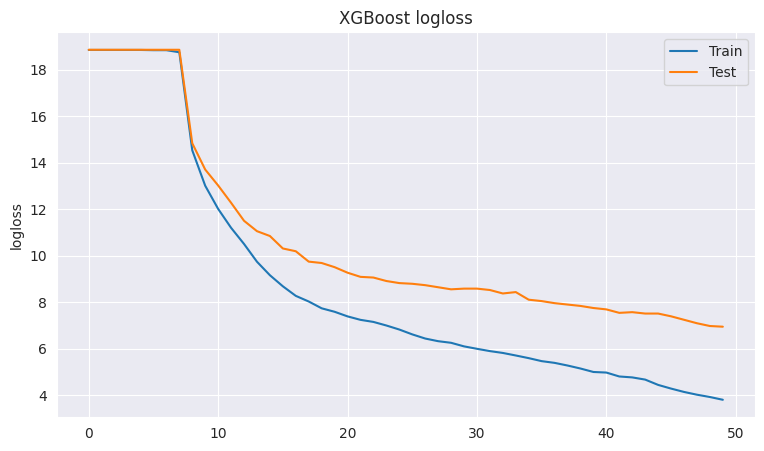

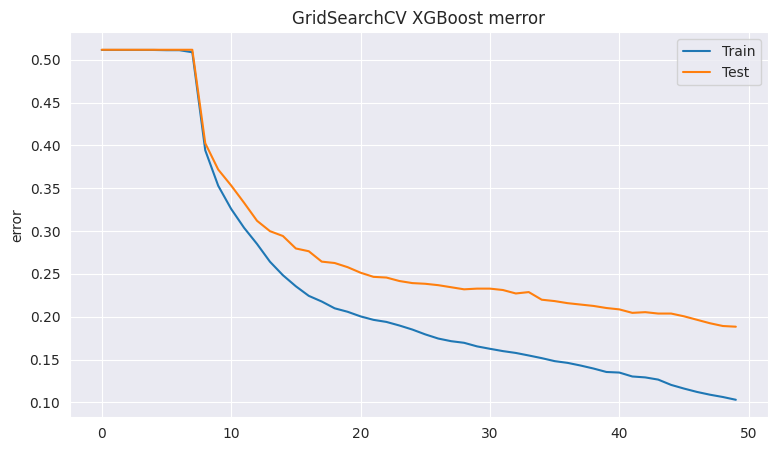


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       633
           1       0.79      0.83      0.81       605

    accuracy                           0.81      1238
   macro avg       0.81      0.81      0.81      1238
weighted avg       0.81      0.81      0.81      1238
 



In [ ]:
# create first xgboost model with the parameters
xgboost_1 = xgboost_base_model(objective = 'binary:hinge',
                               estimators = 50, stop=10, lr = 0.09,
                               depth = 5, sub_sample = 0.9,
                               col_sample = 0.9, alpha = 0.001, lamb=0.8,
                               x_train = ml_train_image,
                               y_train = ml_train_label,
                               x_valid = ml_valid_image,
                               y_valid = ml_valid_label,
                               x_test = ml_test_image,
                               y_test = ml_test_label)

In [ ]:
dir = '/content/drive/MyDrive/monkey/ml_save'
model_name = 'xgb_1'
save_ml_model(xgboost_1, model_name, dir)

this file is already here , it will be replaced
Model saved to /content/drive/MyDrive/monkey/ml_save/xgb_1.dat


[0]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[1]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[2]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[3]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[4]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[5]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[6]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[7]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[8]	validation_0-logloss:18.84491	validation_0-error:0.5

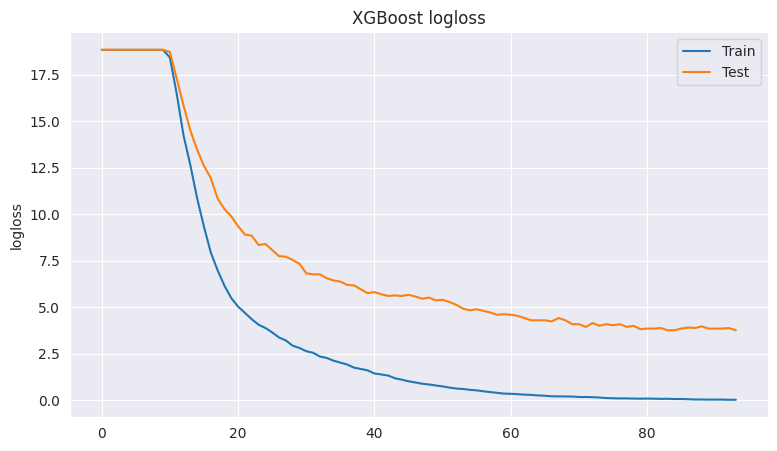

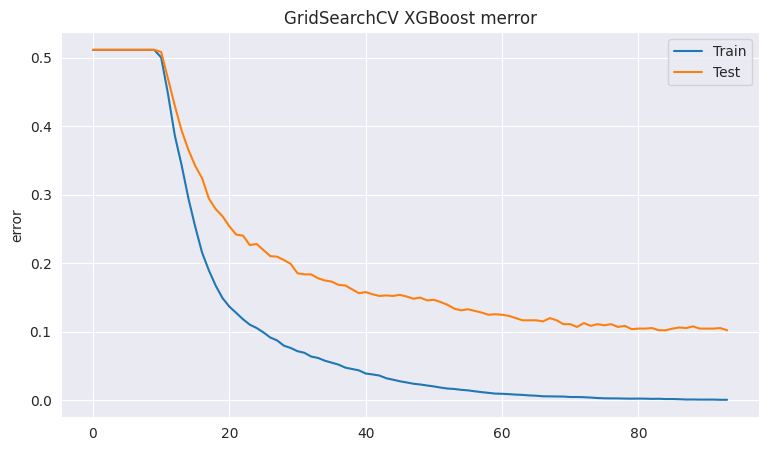


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       633
           1       0.89      0.90      0.90       605

    accuracy                           0.90      1238
   macro avg       0.90      0.90      0.90      1238
weighted avg       0.90      0.90      0.90      1238
 



In [ ]:
# create second xgboost model with the parameters
xgboost_2 = xgboost_base_model(objective = 'binary:hinge',
                               estimators = 100, stop=20,
                               lr = 0.05, depth = 8, sub_sample = 0.9,
                               col_sample = 0.6, alpha = 0.01, lamb = 0.01,
                               x_train = ml_train_image,
                               y_train = ml_train_label,
                               x_valid = ml_valid_image,
                               y_valid = ml_valid_label,
                               x_test = ml_test_image,
                               y_test = ml_test_label)

In [ ]:
model_name = 'xgb_2'
save_ml_model(xgboost_2, model_name, dir)

Model saved to /content/drive/MyDrive/monkey/ml_save/xgb_2.dat


[0]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[1]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[2]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[3]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[4]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[5]	validation_0-logloss:15.92738	validation_0-error:0.43232	validation_1-logloss:16.52947	validation_1-error:0.44867
[6]	validation_0-logloss:13.70945	validation_0-error:0.37212	validation_1-logloss:14.71272	validation_1-error:0.39935
[7]	validation_0-logloss:12.17129	validation_0-error:0.33037	validation_1-logloss:13.40227	validation_1-error:0.36378
[8]	validation_0-logloss:11.00527	validation_0-error:0.2

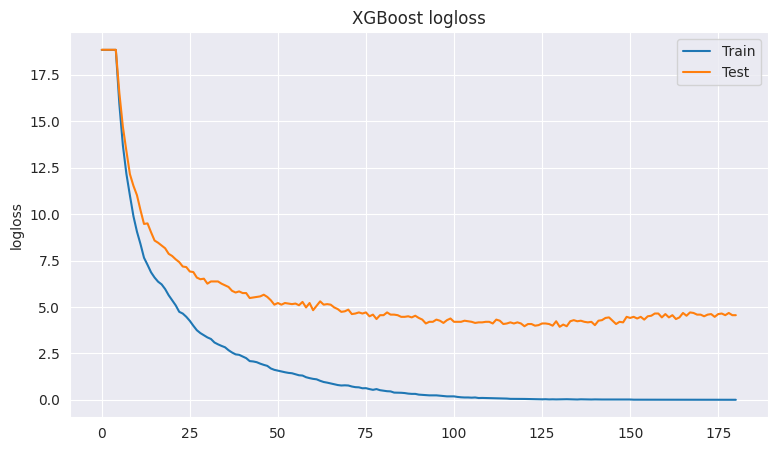

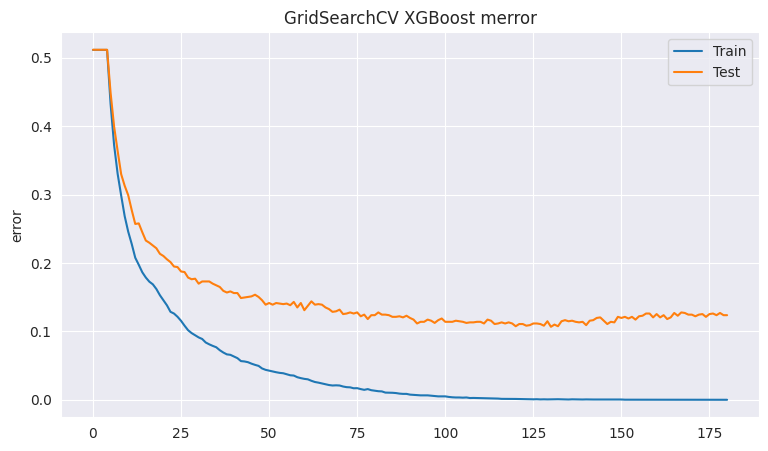


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       633
           1       0.88      0.89      0.88       605

    accuracy                           0.88      1238
   macro avg       0.88      0.88      0.88      1238
weighted avg       0.88      0.88      0.88      1238
 



In [ ]:
# create third xgboost model with the parameters
xgboost_3 = xgboost_base_model(objective = 'binary:hinge',
                               estimators = 500, stop=50,
                               lr = 0.11, depth = 6, sub_sample = 0.5,
                               col_sample = 0.8, alpha = 0.5, lamb = 0.7,
                               x_train = ml_train_image,
                               y_train = ml_train_label,
                               x_valid = ml_valid_image,
                               y_valid = ml_valid_label,
                               x_test = ml_test_image,
                               y_test = ml_test_label)

In [ ]:
model_name = 'xgb_3'
save_ml_model(xgboost_3, model_name, dir)

Model saved to /content/drive/MyDrive/monkey/data/Augmented/Augmented/xgb_3.dat


# **NG BOOST MODEL**
1. install ngboost in colab
2. create ngboost
3. ngboost_1
4. ngboost_2

In [ ]:
!pip install ngboost

In [ ]:
# NGBOOST PART
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli
from ngboost.scores import LogScore

def ngboodt_base_model(estimators, stop,lr,
                       x_train, y_train,
                       x_valid, y_valid,
                       x_test, y_test):
  """
  create a function for ngboost to give us the ability of
  creating more than one ngboost model

  """

  # create ngboost base model
  ngboost_model = NGBClassifier(Dist=Bernoulli,
                                n_estimators = estimators,
                                learning_rate = lr,
                                Score=LogScore,
                                verbose_eval=True)

  # fit on the train and valid data
  ngboost_model.fit(x_train, y_train,
                    early_stopping_rounds = stop,
                    X_val= x_valid,
                    Y_val= y_valid)

  # results for plot
  epochs = estimators
  x_axis = range(0, epochs)
 # plot_ng_model(x_axis)

  # model predict on test data
  y_pred = ngboost_model.predict(x_test)
  report_ml_model(y_test, y_pred)

In [ ]:
# create first ngboost
ngboost_1 = ngboodt_base_model(estimators = 100,
                               stop=10, lr = 0.08,
                               x_train = ml_train_image,
                               y_train = ml_train_label,
                               x_valid = ml_valid_image,
                               y_valid = ml_valid_label,
                               x_test = ml_test_image,
                               y_test = ml_test_label)

[iter 0] loss=0.6929 val_loss=0.6633 scale=2.0000 norm=4.0000
[iter 1] loss=0.6621 val_loss=0.6422 scale=2.0000 norm=3.8865
[iter 2] loss=0.6379 val_loss=0.6240 scale=2.0000 norm=3.8079
[iter 3] loss=0.6176 val_loss=0.6119 scale=2.0000 norm=3.7465
[iter 4] loss=0.6009 val_loss=0.5990 scale=2.0000 norm=3.6990
[iter 5] loss=0.5858 val_loss=0.5900 scale=2.0000 norm=3.6616
[iter 6] loss=0.5740 val_loss=0.5807 scale=2.0000 norm=3.6348
[iter 7] loss=0.5624 val_loss=0.5733 scale=2.0000 norm=3.6115
[iter 8] loss=0.5535 val_loss=0.5671 scale=2.0000 norm=3.5936
[iter 9] loss=0.5457 val_loss=0.5617 scale=2.0000 norm=3.5792
[iter 10] loss=0.5377 val_loss=0.5566 scale=2.0000 norm=3.5639
[iter 11] loss=0.5308 val_loss=0.5510 scale=2.0000 norm=3.5536
[iter 12] loss=0.5238 val_loss=0.5472 scale=2.0000 norm=3.5413
[iter 13] loss=0.5183 val_loss=0.5416 scale=2.0000 norm=3.5330
[iter 14] loss=0.5133 val_loss=0.5387 scale=2.0000 norm=3.5244
[iter 15] loss=0.5081 val_loss=0.5361 scale=2.0000 norm=3.5142
[i

In [ ]:
model_name = 'ngb_1'
model_save = "/content/drive/MyDrive/monkey/ml_save"
save_ml_model(ngboost_1, model_name, model_save)

Model saved to /content/drive/MyDrive/monkey/ml_save/ngb_1.dat


In [ ]:
ngboost_2 = ngboodt_base_model(estimators = 150,
                               stop=15, lr = 0.07,
                               x_train = ml_train_image,
                               y_train = ml_train_label,
                               x_valid = ml_valid_image,
                               y_valid = ml_valid_label,
                               x_test = ml_test_image,
                               y_test = ml_test_label)

[iter 0] loss=0.6929 val_loss=0.6667 scale=2.0000 norm=4.0000
[iter 1] loss=0.6656 val_loss=0.6468 scale=2.0000 norm=3.8985
[iter 2] loss=0.6436 val_loss=0.6295 scale=2.0000 norm=3.8242
[iter 3] loss=0.6248 val_loss=0.6146 scale=2.0000 norm=3.7667
[iter 4] loss=0.6082 val_loss=0.6029 scale=2.0000 norm=3.7195
[iter 5] loss=0.5943 val_loss=0.5920 scale=2.0000 norm=3.6820
[iter 6] loss=0.5819 val_loss=0.5821 scale=2.0000 norm=3.6495
[iter 7] loss=0.5714 val_loss=0.5744 scale=2.0000 norm=3.6265
[iter 8] loss=0.5618 val_loss=0.5672 scale=2.0000 norm=3.6058
[iter 9] loss=0.5531 val_loss=0.5613 scale=2.0000 norm=3.5909
[iter 10] loss=0.5452 val_loss=0.5558 scale=2.0000 norm=3.5729
[iter 11] loss=0.5384 val_loss=0.5522 scale=2.0000 norm=3.5601
[iter 12] loss=0.5330 val_loss=0.5473 scale=2.0000 norm=3.5527
[iter 13] loss=0.5276 val_loss=0.5442 scale=2.0000 norm=3.5432
[iter 14] loss=0.5226 val_loss=0.5411 scale=2.0000 norm=3.5374
[iter 15] loss=0.5178 val_loss=0.5379 scale=2.0000 norm=3.5310
[i

In [ ]:
model_name = 'ngb_2'
model_save = "/content/drive/MyDrive/monkey/ml_save"
save_ml_model(ngboost_2, model_name, model_save)

Model saved to /content/drive/MyDrive/monkey/ml_save/ngb_2.dat


# **vgg16 feature extractor + xgboost classification**
1. vgg16_feature
2. extract feature
3. save features
4. laod features
5. xgboost model 1
6. xgboost model 2

In [ ]:
def vgg16_feature():

  """
  create a vgg network to extract
  the features from train and vlaidation data
  then reshape the features and send them to
  xgboost classifire to predict \

  """

  image_size = (224,224,3)

  # extract features with vgg16
  vgg_feature = tf.keras.applications.VGG16(input_shape = image_size,
                                            include_top = False,
                                            weights = "imagenet")
  vgg_feature.trainable = False
  return vgg_feature

vgg_extractor = vgg16_feature()
vgg_extractor.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
def extract_feature(model, train_image, val_image):

  train_features = model.predict(train_image, verbose=1)
  train_features = train_features.reshape(train_features.shape[0],-1)

  val_features = model.predict(val_image, verbose=1)
  val_features = val_features.reshape(val_features.shape[0], -1)

  return train_features,val_features

train_features, val_features = extract_feature(vgg_extractor,
                                               train_gen,
                                               valid_gen)

In [ ]:
def save_vgg_extractor_features(path, file_name, numpy):
  # create path and names
  dummy_path = os.path.join(path, file_name)
  numpy_path = dummy_path + ".npy"

  # delete if there is file
  if os.path.exists(numpy_path):
    print("this file is already here , it will be replaced")
    os.remove(numpy_path)

  # save the file
  np.save(numpy_path, numpy)
  print(f"featuers saved to {numpy_path}")

path = "/content/drive/MyDrive/monkey/vgg_features"
save_vgg_extractor_features(path, "train_feature", train_features)
save_vgg_extractor_features(path, "val_features", val_features)

In [ ]:
def load_vgg_extractor_features(path_file):
  """
  load the processed images

  """
  # laod the data |
  dummy = np.load(path_file)
  return dummy

# call the function and load the data
train_features = laod_numpy("/content/drive/MyDrive/monkey/vgg_features/train_feature.npy")
val_features = laod_numpy("/content/drive/MyDrive/monkey/vgg_features/val_features.npy")

In [ ]:
train_features.shape

(7425, 25088)

[0]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[1]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[2]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[3]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[4]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[5]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[6]	validation_0-logloss:8.33582	validation_0-error:0.22626	validation_1-logloss:15.33816	validation_1-error:0.41633
[7]	validation_0-logloss:6.98621	validation_0-error:0.18963	validation_1-logloss:14.83185	validation_1-error:0.40259
[8]	validation_0-logloss:3.02174	validation_0-error:0.0820

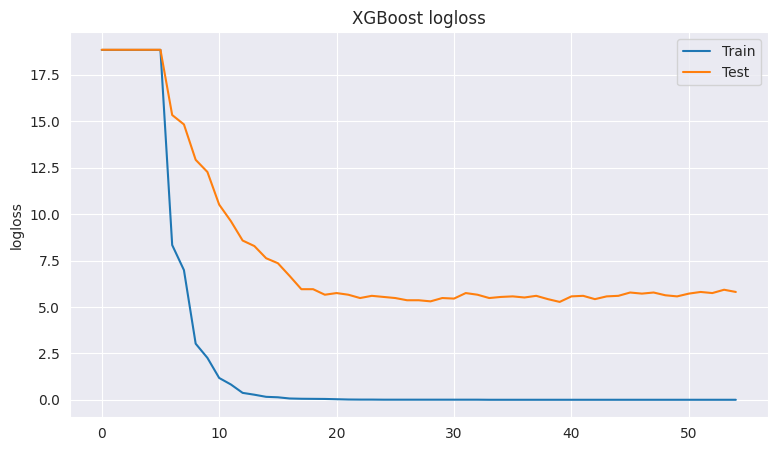

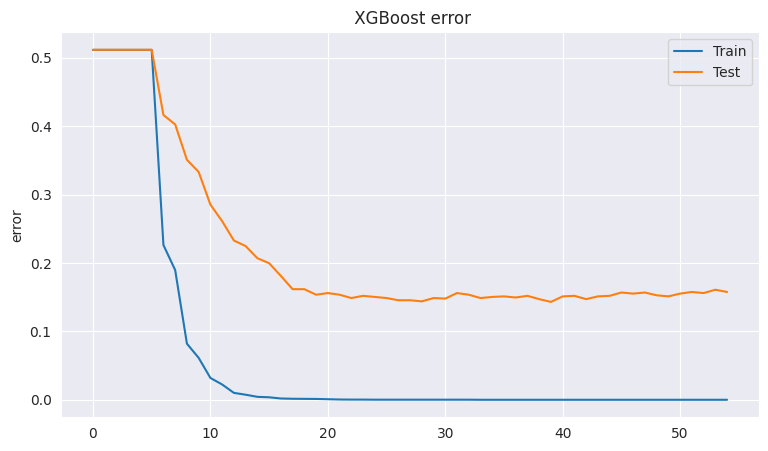


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       633
           1       0.86      0.85      0.85       604

    accuracy                           0.86      1237
   macro avg       0.86      0.86      0.86      1237
weighted avg       0.86      0.86      0.86      1237
 



In [ ]:
# call xgboost function to fit on

"""
create new xgboost vgg for show your working
cahnge the parameters

"""
vggg_xgboost = xgboost_base_model(objective = 'binary:hinge',
                               estimators = 200, stop=15,
                               lr = 0.08, depth = 12, sub_sample = 0.8,
                               col_sample = 0.8, alpha = 0.0, lamb = 0.0,
                               x_train = train_features,
                               y_train = ml_train_label,
                               x_valid = val_features,
                               y_valid = ml_valid_label,
                               x_test = ml_test_image,
                               y_test = ml_test_label)

In [ ]:
model_name = 'vgg16+xgboost_1'
model_save = "/content/drive/MyDrive/monkey/ml_save"
save_ml_model(vggg_xgboost, model_name, model_save)

Model saved to /content/drive/MyDrive/monkey/ml_save/vgg16+xgboost_1.dat


[0]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[1]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[2]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[3]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[4]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[5]	validation_0-logloss:16.53768	validation_0-error:0.44889	validation_1-logloss:17.21448	validation_1-error:0.46726
[6]	validation_0-logloss:16.03157	validation_0-error:0.43515	validation_1-logloss:17.06556	validation_1-error:0.46322
[7]	validation_0-logloss:14.12128	validation_0-error:0.38330	validation_1-logloss:15.78490	validation_1-error:0.42846
[8]	validation_0-logloss:13.30258	validation_0-error:0.3

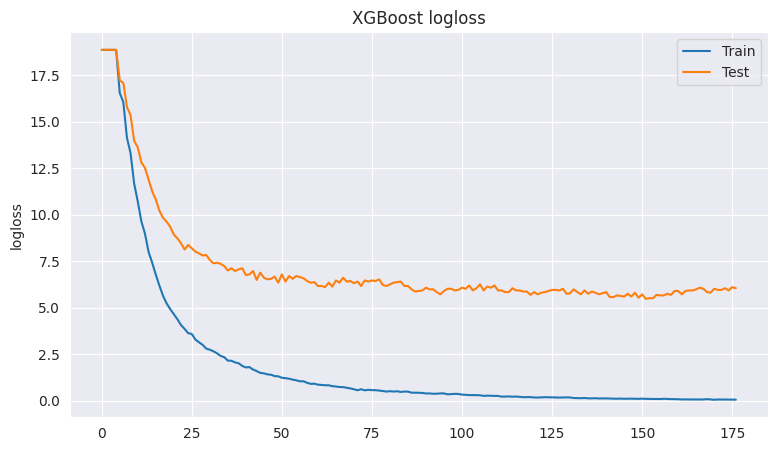

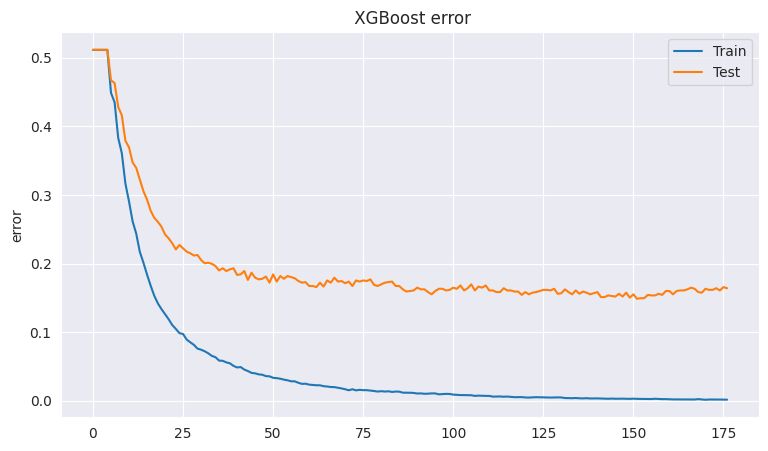


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       633
           1       0.87      0.82      0.84       604

    accuracy                           0.85      1237
   macro avg       0.85      0.85      0.85      1237
weighted avg       0.85      0.85      0.85      1237
 



In [ ]:
vggg_xgboost_2 = xgboost_base_model(objective = 'binary:hinge',
                                    estimators = 200, stop=25,
                                    lr = 0.09, depth = 12, sub_sample = 0.2,
                                    col_sample = 0.2, alpha = 0.5, lamb = 0.5,
                                    x_train = train_features,
                                    y_train = ml_train_label,
                                    x_valid = val_features,
                                    y_valid = ml_valid_label,
                                    x_test = ml_test_image,
                                    y_test = ml_test_label)

In [ ]:
model_name = 'vgg16+xgboost_2'
model_save = "/content/drive/MyDrive/monkey/ml_save"
save_ml_model(vggg_xgboost_2, model_name, model_save)

Model saved to /content/drive/MyDrive/monkey/ml_save/vgg16+xgboost_2.dat


# **Densenet121 feature extractor +xgboost classification**

In [ ]:
def densenet_feature():

  """
  create a DenseNet121 network to extract
  the features from train and vlaidation data
  then reshape the features and send them to
  xgboost classifire to predict \

  """

  image_size = (224,224,3)

  # extract features with densenet121
  vgg_feature = tf.keras.applications.densenet.DenseNet121(input_shape = image_size,
                                            include_top = False,
                                            weights = "imagenet")
  densenet121_feature.trainable = False
  return  densenet121_feature

dense_extractor = densenet_feature()
dense_extractor.summary()



29084464/29084464 [==============================] - 2s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [ ]:
def extract_feature(model, train_image, val_image):

  train_features = model.predict(train_image, verbose=1)
  train_features = train_features.reshape(train_features.shape[0],-1)

  val_features = model.predict(val_image, verbose=1)
  val_features = val_features.reshape(val_features.shape[0], -1)

  return train_features,val_features

train_features, val_features = extract_feature(dense_extractor,
                                               train_gen,
                                               valid_gen)

In [ ]:
def save_dense_extractor_features(path, file_name, numpy):
  # create path and names
  dummy_path = os.path.join(path, file_name)
  numpy_path = dummy_path + ".npy"

  # delete if there is file
  if os.path.exists(numpy_path):
    print("this file is already here , it will be replaced")
    os.remove(numpy_path)

  # save the file
  np.save(numpy_path, numpy)
  print(f"featuers saved to {numpy_path}")

path = "/content/drive/MyDrive/monkey/dense_features"
save_dense_extractor_features(path, "train_feature", train_features)
save_dense_extractor_features(path, "val_features", val_features)



In [ ]:
def load_dense_extractor_features(path_file):
  """
  load the processed images

  """
  # laod the data |
  dummy = np.load(path_file)
  return dummy

# call the function and load the data
train_features = laod_numpy("/content/drive/MyDrive/monkey/dense_features/train_feature.npy")
val_features = laod_numpy("/content/drive/MyDrive/monkey/dense_features/val_features.npy")


[0]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[1]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[2]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[3]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[4]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[5]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[6]	validation_0-logloss:5.78546	validation_0-error:0.15704	validation_1-logloss:13.52141	validation_1-error:0.36702
[7]	validation_0-logloss:5.88469	validation_0-error:0.15973	validation_1-logloss:13.84902	validation_1-error:0.37591
[8]	validation_0-logloss:1.94503	validation_0-error:0.0527

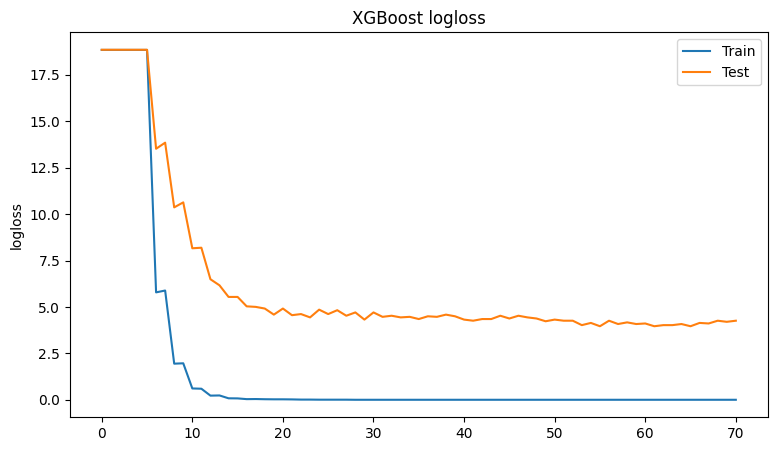

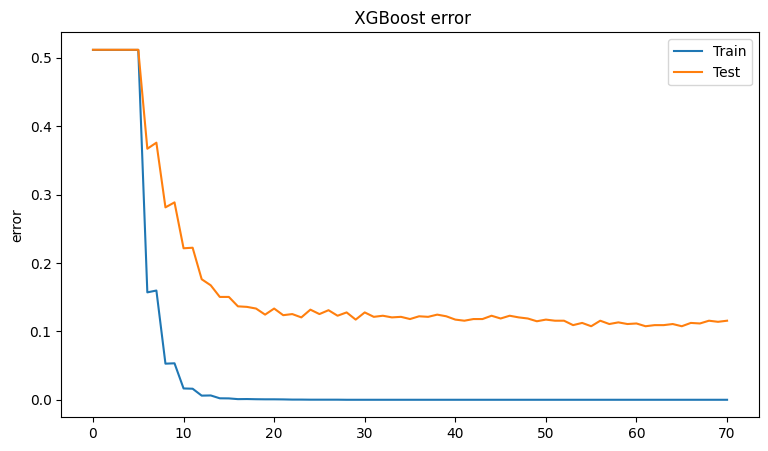


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       633
           1       0.89      0.90      0.89       604

    accuracy                           0.89      1237
   macro avg       0.89      0.89      0.89      1237
weighted avg       0.89      0.89      0.89      1237
 



In [ ]:
# call xgboost function to fit on
"""
create new xgboost vgg for show your working
cahnge the parameters

"""
dense_xgboost = xgboost_base_model(objective = 'binary:hinge',
                               estimators = 200, stop=15,
                               lr = 0.08, depth = 12, sub_sample = 0.8,
                               col_sample = 0.8, alpha = 0.0, lamb = 0.0,
                               x_train = train_features,
                               y_train = ml_train_label,
                               x_valid = val_features,
                               y_valid = ml_valid_label,
                               x_test = ml_test_image,
                               y_test = ml_test_label)
model_name = 'dense+xgboost_1'
model_save = "/content/drive/MyDrive/monkey/ml_save"

[0]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[1]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[2]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[3]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[4]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[5]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[6]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[7]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[8]	validation_0-logloss:18.84491	validation_0-error:0.5

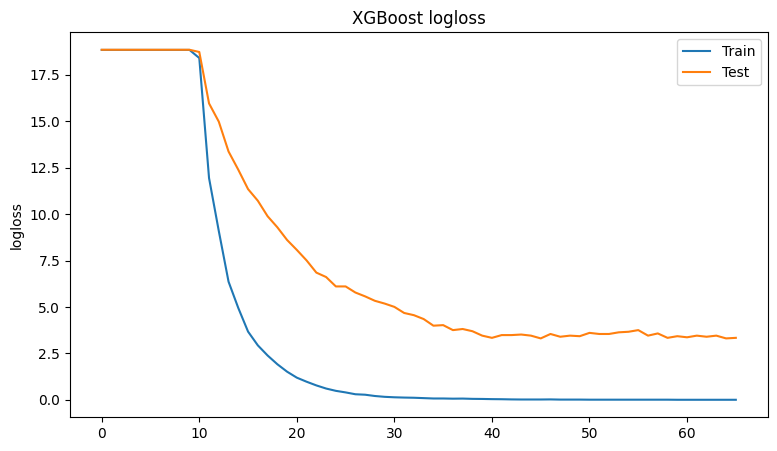

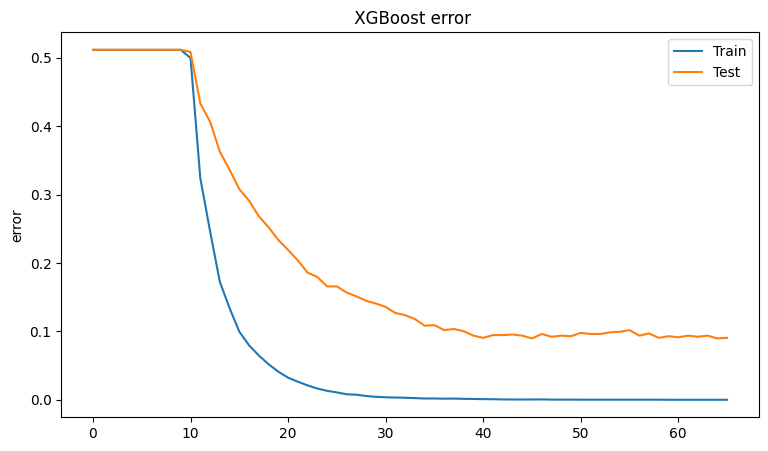


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       633
           1       0.91      0.91      0.91       604

    accuracy                           0.91      1237
   macro avg       0.91      0.91      0.91      1237
weighted avg       0.91      0.91      0.91      1237
 



In [ ]:
# call xgboost function to fit on
"""
create new xgboost dense121 for show your working
cahnge the parameters

"""
dense_xgboost = xgboost_base_model(objective = 'binary:hinge',
                               estimators = 100, stop=20,
                               lr = 0.05, depth = 8, sub_sample = 0.9,
                               col_sample = 0.6, alpha = 0.01, lamb = 0.01,
                               x_train = train_features,
                               y_train = ml_train_label,
                               x_valid = val_features,
                               y_valid = ml_valid_label,
                               x_test = ml_test_image,
                               y_test = ml_test_label)
model_name = 'dense+xgboost_2'
model_save = "/content/drive/MyDrive/monkey/ml_save"

[0]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[1]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[2]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[3]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[4]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[5]	validation_0-logloss:4.43089	validation_0-error:0.12027	validation_1-logloss:13.22358	validation_1-error:0.35893
[6]	validation_0-logloss:3.66181	validation_0-error:0.09939	validation_1-logloss:12.92575	validation_1-error:0.35085
[7]	validation_0-logloss:1.15610	validation_0-error:0.03138	validation_1-logloss:10.69204	validation_1-error:0.29022
[8]	validation_0-logloss:0.90801	validation_0-error:0.02465

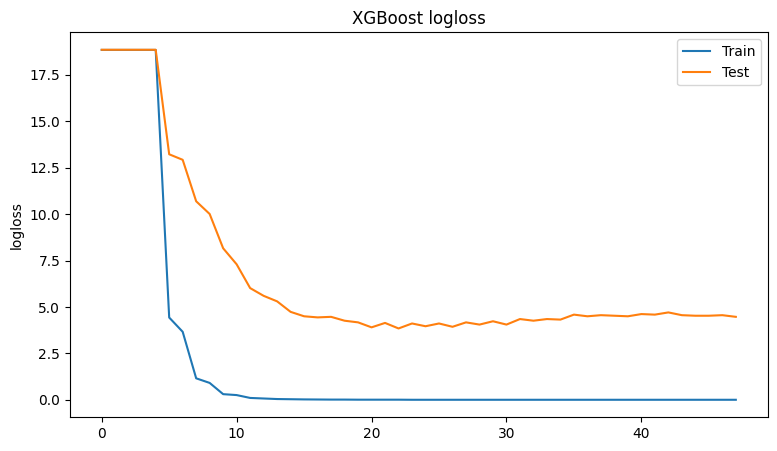

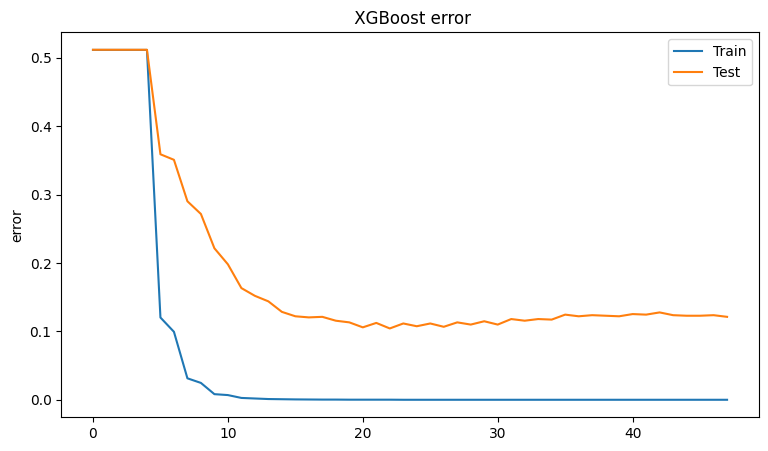


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       633
           1       0.90      0.89      0.89       604

    accuracy                           0.90      1237
   macro avg       0.90      0.90      0.90      1237
weighted avg       0.90      0.90      0.90      1237
 



In [ ]:
# call xgboost function to fit on
"""
create new xgboost densenet121 for show your working
we can cahnge the parameters

"""
dense_xgboost = xgboost_base_model(objective = 'binary:hinge',
                               estimators = 100, stop=25,
                               lr = 0.05, depth = 15, sub_sample = 0.9,
                               col_sample = 0.6, alpha = 0.02, lamb = 0.05,
                               x_train = train_features,
                               y_train = ml_train_label,
                               x_valid = val_features,
                               y_valid = ml_valid_label,
                               x_test = ml_test_image,
                               y_test = ml_test_label)
model_name = 'dense+xgboost_3'
model_save = "/content/drive/MyDrive/monkey/ml_save"

[0]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[1]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[2]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[3]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[4]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[5]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[6]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[7]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[8]	validation_0-logloss:18.84491	validation_0-error:0.5

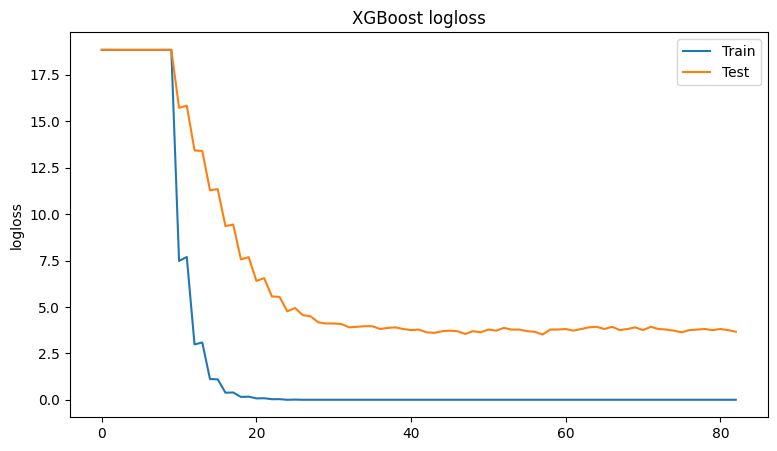

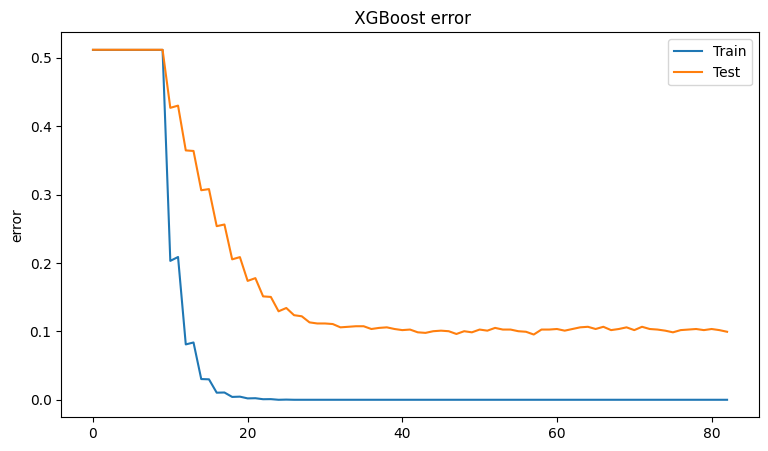


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       633
           1       0.91      0.90      0.90       604

    accuracy                           0.90      1237
   macro avg       0.90      0.90      0.90      1237
weighted avg       0.90      0.90      0.90      1237
 



In [ ]:
# call xgboost function to fit on
"""
create new xgboost dense121  for show your working
cahnge the parameters

"""
dense_xgboost = xgboost_base_model(objective = 'binary:hinge',
                               estimators = 100, stop=25,
                               lr = 0.05, depth = 15, sub_sample = 0.8,
                               col_sample = 0.5, alpha = 0.04, lamb = 0.06,
                               x_train = train_features,
                               y_train = ml_train_label,
                               x_valid = val_features,
                               y_valid = ml_valid_label,
                               x_test = ml_test_image,
                               y_test = ml_test_label)

model_name = 'dense+xgboost_4'
model_save = "/content/drive/MyDrive/monkey/ml_save"

# **Densenet121 feature extractor +xgboost classification**

In [ ]:
def DenseNet201_feature():
  """
  create a DenseNet201 network to extract
  the features from train and vlaidation data
  then reshape the features and send them to
  xgboost classifire to predict

  """

  image_size = (224,224,3)

  # extract features with Densenet201
  DenseNet201 = tf.keras.applications.DenseNet201(input_shape = image_size,
                                            include_top = False,
                                            weights = "imagenet")
  DenseNet201.trainable = False
  return DenseNet201

DenseNet201_extractor = DenseNet201_feature()
DenseNet201_extractor.summary()

74836368/74836368 [==============================] - 5s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [ ]:
def extract_feature(model, train_image, val_image):

  train_features = model.predict(train_image, verbose=1)
  train_features = train_features.reshape(train_features.shape[0],-1)

  val_features = model.predict(val_image, verbose=1)
  val_features = val_features.reshape(val_features.shape[0], -1)

  return train_features,val_features

train_features, val_features = extract_feature(DenseNet201_extractor,
                                               train_gen,
                                               valid_gen)

83/83 [==============================] - 478s 6s/step


In [ ]:
def save_densenet201_extractor_features(path, file_name, numpy):
  # create path and names
  dummy_path = os.path.join(path, file_name)
  numpy_path = dummy_path + ".npy"

  # delete if there is file
  if os.path.exists(numpy_path):
    print("this file is already here , it will be replaced")
    os.remove(numpy_path)

  # save the file
  np.save(numpy_path, numpy)
  print(f"featuers saved to {numpy_path}")

path = "/content/drive/MyDrive/monkey/dense_201"
save_densenet201_extractor_features(path, "train_feature", train_features)
save_densenet201_extractor_features(path, "val_features", val_features)


featuers saved to /content/drive/MyDrive/monkey/dense_201/train_feature.npy
featuers saved to /content/drive/MyDrive/monkey/dense_201/val_features.npy


In [ ]:
def load_dense_extractor_features(path_file):
  """
  load the processed images

  """
  # laod the data |
  dummy = np.load(path_file)
  return dummy

# call the function and load the data
train_features = load_dense_extractor_features("/content/drive/MyDrive/monkey/dense_201/train_feature.npy")
val_features = load_dense_extractor_features("/content/drive/MyDrive/monkey/dense_201/val_features.npy")

In [ ]:
# call xgboost function to fit on
"""
create new xgboost vgg for show your working
cahnge the parameters

"""
dense_xgboost = xgboost_base_model(objective = 'binary:hinge',
                               estimators = 100, stop=20,
                               lr = 0.05, depth = 8, sub_sample = 0.9,
                               col_sample = 0.6, alpha = 0.01, lamb = 0.01,
                               x_train = train_features,
                               y_train = ml_train_label,
                               x_valid = val_features,
                               y_valid = ml_valid_label,
                               x_test = ml_test_image,
                               y_test = ml_test_label)
model_name = 'densenet201+xgboost_1'
model_save = "/content/drive/MyDrive/monkey/ml_save"

# **Densenet121 feature extractor +xgboost classification**

In [ ]:
def vit_feature():

    """
    create a Vision Transformer network to extract
    the features from train and validation data
    then reshape the features and send them to
    xgboost classifier to predict

    """

    image_size = (224, 224)

    # extract features with ViT
    vit_feature = vit.vit_b16(
        image_size=image_size,
        activation='sigmoid',
        pretrained=True,
        include_top=False,
        pretrained_top=False
    )
    vit_feature.trainable = False
    return vit_feature

vit_extractor = vit_feature()
vit_extractor.summary()

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape_3 (Reshape)         (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [ ]:
train_features, val_features = extract_feature(vit_extractor,
                                               train_gen,
                                               valid_gen)

83/83 [==============================] - 390s 5s/step


[0]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[1]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[2]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[3]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[4]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[5]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[6]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[7]	validation_0-logloss:18.84491	validation_0-error:0.51152	validation_1-logloss:18.85253	validation_1-error:0.51172
[8]	validation_0-logloss:18.84491	validation_0-error:0.5

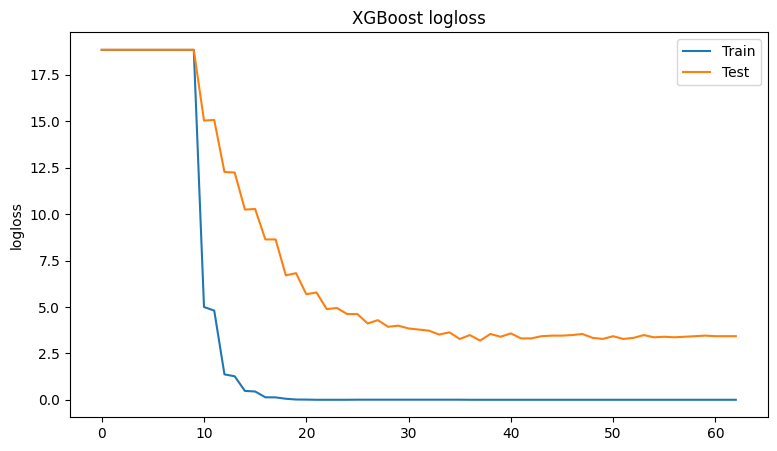

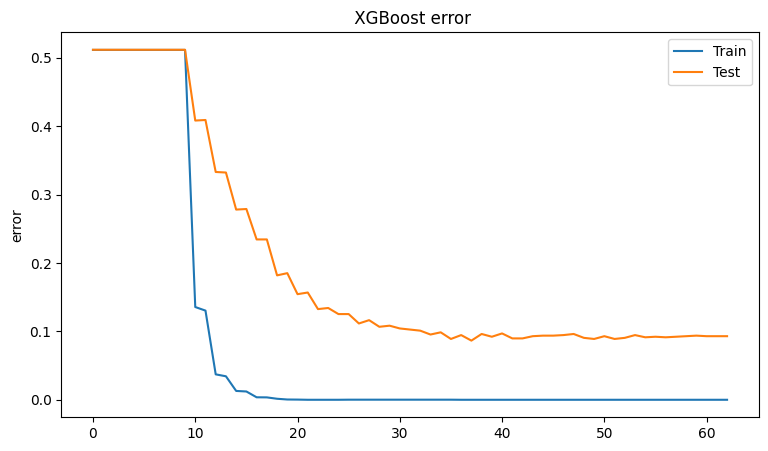


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       633
           1       0.92      0.90      0.91       604

    accuracy                           0.91      1237
   macro avg       0.91      0.91      0.91      1237
weighted avg       0.91      0.91      0.91      1237
 



In [ ]:
vit_xgboost = xgboost_base_model(objective = 'binary:hinge',
                               estimators = 100, stop=25,
                               lr = 0.05, depth = 15, sub_sample = 0.9,
                               col_sample = 0.6, alpha = 0.02, lamb = 0.05,
                               x_train = train_features,
                               y_train = ml_train_label,
                               x_valid = val_features,
                               y_valid = ml_valid_label,
                               x_test = ml_test_image,
                               y_test = ml_test_label)

In [ ]:
model_name = 'vit+xgboost_3'
model_save = "monkey/ml_save"
save_ml_model(vit_xgboost, model_name, model_save)

Model saved to monkey/ml_save\vit+xgboost_3.dat
